In [90]:
from Data_manager.UserUtils import *
from Data_manager.split_functions.split_train_validation_random_holdout import \
    split_train_in_two_percentage_global_sample
URM_all = getURM_all()
URM_train_validation, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_validation, train_percentage = 0.80)

In [91]:
# SETUP EVALUATORS
from Evaluation.Evaluator import EvaluatorHoldout

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2615 (20.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 2165 (17.1%) Users that have less than 1 test interactions


In [92]:
import numpy as np 
import scipy.sparse as sps

profile_length = np.ediff1d(sps.csr_matrix(URM_train_validation).indptr)
profile_length, profile_length.shape

(array([34, 34,  4, ...,  7, 19, 59], dtype=int32), (12638,))

In [93]:
from Hybrid import *
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender, MultiThreadSLIM_SLIMElasticNetRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender


MAP_recommender_per_group = {}

collaborative_recommender_class = {"UserKNNCF": UserKNNCFRecommender,
                                   "ItemKNNCF": ItemKNNCFRecommender,
                                   "P3alpha": P3alphaRecommender,
                                   "RP3beta": RP3betaRecommender,
                                   "SLIM_ELASTIC": MultiThreadSLIM_SLIMElasticNetRecommender,
                                   "EASE_R": EASE_R_Recommender,
                                   }
collaborative_recommender_class.items()

recommender_object_dict = {}

for label, recommender_class in collaborative_recommender_class.items():
    recommender_object = recommender_class(URM_train_validation)
    recommender_object_dict[label] = recommender_object
    
    
recommender_object_dict["SLIM_ELASTIC"].fit(topK=8894, l1_ratio=0.05565733019999427, alpha=0.0012979360257937668, workers=7)
recommender_object_dict["P3alpha"].fit(topK=76, alpha=0.377201600381895, normalize_similarity=True)
recommender_object_dict["RP3beta"].fit(topK=101, alpha=0.3026342852596128, beta=0.058468783118329024)
recommender_object_dict["UserKNNCF"].fit(topK=445, shrink=3, similarity='asymmetric', normalize=True,
                                       feature_weighting='none', asymmetric_alpha=0.402515)

recommender_object_dict["ItemKNNCF"].fit(topK=31, shrink=435, similarity='tversky', normalize=True,
                                       feature_weighting='BM25', tversky_alpha=0.17113169506422393, tversky_beta=0.5684024974085575)
recommender_object_dict["EASE_R"].fit(topK=24, l2_norm=37.54323189430143)


UserKNNCFRecommender: URM Detected 218 ( 1.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 122 ( 0.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 218 ( 1.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 122 ( 0.5%) items with no interactions.
P3alphaRecommender: URM Detected 218 ( 1.7%) users with no interactions.
P3alphaRecommender: URM Detected 122 ( 0.5%) items with no interactions.
RP3betaRecommender: URM Detected 218 ( 1.7%) users with no interactions.
RP3betaRecommender: URM Detected 122 ( 0.5%) items with no interactions.
SLIMElasticNetRecommender: URM Detected 218 ( 1.7%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 122 ( 0.5%) items with no interactions.
EASE_R_Recommender: URM Detected 218 ( 1.7%) users with no interactions.
EASE_R_Recommender: URM Detected 122 ( 0.5%) items with no interactions.


100%|█████████▉| 22192/22222 [04:14<00:00, 51.49it/s] 

P3alphaRecommender: Similarity column 22222 (100.0%), 4094.86 column/sec. Elapsed time 5.43 sec


100%|█████████▉| 22216/22222 [04:30<00:00, 51.49it/s]

RP3betaRecommender: Similarity column 22222 (100.0%), 2865.36 column/sec. Elapsed time 7.76 sec
Similarity column 12638 (100.0%), 5529.35 column/sec. Elapsed time 2.29 sec
Similarity column 22222 (100.0%), 5043.05 column/sec. Elapsed time 4.41 sec
EASE_R_Recommender: Fitting model... 


KeyboardInterrupt: 

# XGBOOST

In [37]:
import pandas as pd
import tqdm

n_users, n_items = URM_train.shape
training_dataframe = pd.DataFrame(index=range(0,n_users), columns = ["ItemID"])
training_dataframe.index.name='UserID'
training_dataframe = training_dataframe.explode("ItemID")

In [38]:
cutoff = 35

for user_id in tqdm.tqdm(range(n_users)):    
    recommendations = recommender_object_dict["SLIM_ELASTIC"].recommend(user_id, cutoff = cutoff)
    training_dataframe.loc[user_id, "ItemID"] = recommendations

training_dataframe = training_dataframe.explode("ItemID")
training_dataframe


100%|██████████| 12638/12638 [00:12<00:00, 982.03it/s] 


,ItemID
UserID,
0,674
0,587
0,953
0,1449
0,2857
...,...
12637,5155
12637,3573
12637,229


In [39]:
urm_validation_coo = sps.coo_matrix(URM_validation)

correct_recommendations = pd.DataFrame({"UserID": urm_validation_coo.row,
                                        "ItemID": urm_validation_coo.col})
training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')

training_dataframe["Label"] = training_dataframe["Exist"] == "both"
training_dataframe.drop(columns = ['Exist'], inplace=True)
training_dataframe

,UserID,ItemID,Label
0,0,674,False
1,0,587,False
2,0,953,False
3,0,1449,False
4,0,2857,False
...,...,...,...
442325,12637,5155,False
442326,12637,3573,False
442327,12637,229,False
442328,12637,45,False


## Popolate the dataframe with data

In [40]:
# training_dataframe = training_dataframe.set_index('UserID')
# 
# for user_id in tqdm.tqdm(range(n_users)):       
#     for rec_label, rec_instance in recommender_object_dict.items():
#         
#         item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()
#         
#         all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)
# 
#         training_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list] 
# 
# training_dataframe = training_dataframe.reset_index()
# training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
# training_dataframe

from joblib import Parallel, delayed
training_dataframe = training_dataframe.set_index('UserID')

def compute_scores_for_user(user_id, rec_label, rec_instance, training_dataframe):
    item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()
    all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute=item_list)
    training_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list]

n_users = range(n_users) # Convert n_users to a range for parallelization

for rec_label, rec_instance in tqdm.tqdm(recommender_object_dict.items()):
    # Parallelize the computation for each user
    Parallel(n_jobs=-1)(delayed(compute_scores_for_user)(user_id, rec_label, rec_instance, training_dataframe)
                        for user_id in n_users)

training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns={"index": "UserID"})
training_dataframe


100%|██████████| 12638/12638 [03:23<00:00, 62.01it/s]


,UserID,ItemID,Label,UserKNNCF,ItemKNNCF,P3alpha,RP3beta,SLIM_ELASTIC,EASE_R
0,0,674,False,25.459816,0.418581,0.269921,0.257277,0.513138,0.345122
1,0,587,False,28.739079,0.262327,0.247522,0.215135,0.413460,0.250374
2,0,953,False,254.731491,0.176879,0.129912,0.105088,0.363896,0.258398
3,0,1449,False,10.497734,0.317668,0.105149,0.103285,0.214235,0.139102
4,0,2857,False,1.720611,0.169719,0.047240,0.042967,0.203003,0.134388
...,...,...,...,...,...,...,...,...,...
442325,12637,5155,False,6.664634,0.092803,0.022766,0.017522,0.130661,0.000000
442326,12637,3573,False,3.214010,0.169824,0.047651,0.040343,0.127956,0.063303
442327,12637,229,False,1.860506,0.052756,0.024457,0.054181,0.127406,0.042995
442328,12637,45,False,6.342069,0.055712,0.000000,0.000000,0.126536,0.000000


In [41]:
item_popularity = np.ediff1d(sps.csc_matrix(URM_train).indptr)
training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train).indptr)
training_dataframe['user_profile_len'] = user_popularity[training_dataframe["UserID"].values.astype(int)]

training_dataframe

,UserID,ItemID,Label,UserKNNCF,ItemKNNCF,P3alpha,RP3beta,SLIM_ELASTIC,EASE_R,item_popularity,user_profile_len
0,0,674,False,25.459816,0.418581,0.269921,0.257277,0.513138,0.345122,290,26
1,0,587,False,28.739079,0.262327,0.247522,0.215135,0.413460,0.250374,453,26
2,0,953,False,254.731491,0.176879,0.129912,0.105088,0.363896,0.258398,121,26
3,0,1449,False,10.497734,0.317668,0.105149,0.103285,0.214235,0.139102,78,26
4,0,2857,False,1.720611,0.169719,0.047240,0.042967,0.203003,0.134388,49,26
...,...,...,...,...,...,...,...,...,...,...,...
442325,12637,5155,False,6.664634,0.092803,0.022766,0.017522,0.130661,0.000000,123,49
442326,12637,3573,False,3.214010,0.169824,0.047651,0.040343,0.127956,0.063303,43,49
442327,12637,229,False,1.860506,0.052756,0.024457,0.054181,0.127406,0.042995,211,49
442328,12637,45,False,6.342069,0.055712,0.000000,0.000000,0.126536,0.000000,598,49


In [42]:
training_dataframe = training_dataframe.sort_values("UserID").reset_index()
training_dataframe.drop(columns = ['index'], inplace=True)
training_dataframe

,UserID,ItemID,Label,UserKNNCF,ItemKNNCF,P3alpha,RP3beta,SLIM_ELASTIC,EASE_R,item_popularity,user_profile_len
0,0,674,False,25.459816,0.418581,0.269921,0.257277,0.513138,0.345122,290,26
1,0,1329,False,3.770871,0.074778,0.013834,0.012299,0.097821,0.036436,66,26
2,0,7944,False,4.741381,0.167184,0.015934,0.046910,0.096604,0.056721,45,26
3,0,588,False,7.925531,0.023570,0.000000,0.000000,0.096195,0.000000,294,26
4,0,677,False,8.330367,0.072731,0.037505,0.030481,0.095428,0.092390,231,26
...,...,...,...,...,...,...,...,...,...,...,...
442325,12637,44,True,8.452390,0.111657,0.000000,0.056608,0.189711,0.214264,1002,49
442326,12637,694,False,10.458596,0.310869,0.039786,0.060398,0.180768,0.119325,87,49
442327,12637,696,False,6.278895,0.158289,0.037991,0.044560,0.166041,0.065406,68,49
442328,12637,896,False,0.887850,0.108832,0.037392,0.043921,0.164726,0.131720,88,49


In [43]:
groups = training_dataframe.groupby("UserID").size().values
groups

array([35, 35, 35, ..., 35, 35, 35])

# XGBoss train

In [44]:
from xgboost import XGBRanker

n_estimators = 1000
learning_rate = 0.19823429576094637
reg_alpha = 47
reg_lambda = 0.313
max_depth = 3
max_leaves = 0
grow_policy = "depthwise"
objective = "pairwise"
booster = "gbtree"
use_user_profile = False
random_seed = None

colsample_bytree = 0.6113704247857885
gamma = 8.964184693722684
min_child_weight = 7.0

XGB_model = XGBRanker(objective='rank:{}'.format(objective),
                      n_estimators = int(n_estimators),
                      random_state = random_seed,
                      learning_rate = learning_rate,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      max_depth = int(max_depth),
                      max_leaves = int(max_leaves),
                      grow_policy = grow_policy,
                      verbosity = 0, # 2 if self.verbose else 0,
                      booster = booster,
                      colsample_bytree = colsample_bytree,
                      gamma = gamma,
                      min_child_weight = min_child_weight,
                      tree_method = "hist"
                      )


In [53]:
training_dataframe.ItemID = training_dataframe.ItemID.astype("int64")

X_train = training_dataframe.drop(columns=["Label", "UserID", "ItemID"])
y_train = training_dataframe["Label"]

XGB_model.fit(X_train,
          y_train,
          group=groups,
          verbose=True)



XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None,
          colsample_bytree=0.6113704247857885, device=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=8.964184693722684,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.19823429576094637,
          max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
          max_delta_step=None, max_depth=3, max_leaves=0, min_child_weight=7.0,
          missing=nan, monotone_constraints=None, multi_strategy=None,
          n_estimators=1000, n_jobs=None, num_parallel_tree=None,
          objective='rank:pairwise', ...)

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

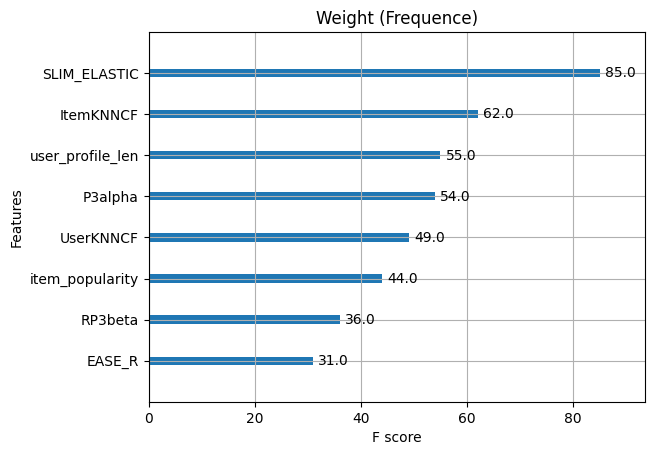

In [54]:
%matplotlib inline
from xgboost import plot_importance
plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')

In [94]:
recommender_object_dict.pop("EASE_R")

In [ ]:
import  Recommenders.XGBossEnsembler as XgBoostEnsembler
from importlib import reload
reload(XgBoostEnsembler)

model = XgBoostEnsembler.XgBoostEnsembler(URM_train_validation, URM_val=URM_test, recommenders=recommender_object_dict)
model.fit()


  0%|          | 35/12638 [00:00<00:36, 341.22it/s]

XgBoostEnsembler: URM Detected 218 ( 1.7%) users with no interactions.
XgBoostEnsembler: URM Detected 122 ( 0.5%) items with no interactions.
CREATING THE DATAFRAME



100%|██████████| 12638/12638 [00:15<00:00, 827.70it/s]

  0%|          | 1/12638 [00:00<29:35,  7.12it/s]

POPULATING THE DATAFRAME



  4%|▎         | 456/12638 [00:07<03:25, 59.29it/s]

In [ ]:
from Data_manager.UserUtils import *
from Recommenders.NonPersonalizedRecommender import TopPop

topPop = TopPop(URM_all)
topPop.fit()
generateSubmission(model, topPop)

In [89]:
evaluator_test.evaluateRecommender(model2)

  9%|▉         | 92/1000 [00:00<00:00, 915.78it/s]

CREATING THE DATAFRAME


  1%|▏         | 13/1000 [00:00<00:07, 125.64it/s]

POPULATING THE DATAFRAME


 11%|█         | 109/1000 [00:00<00:00, 1087.94it/s]

CREATING THE DATAFRAME


  1%|▏         | 13/1000 [00:00<00:07, 127.01it/s]

POPULATING THE DATAFRAME


 11%|█         | 107/1000 [00:00<00:00, 1068.63it/s]

CREATING THE DATAFRAME


  1%|▏         | 13/1000 [00:00<00:07, 126.41it/s]

POPULATING THE DATAFRAME


 11%|█         | 107/1000 [00:00<00:00, 1063.97it/s]

CREATING THE DATAFRAME


  1%|▏         | 14/1000 [00:00<00:07, 133.25it/s]

POPULATING THE DATAFRAME


 11%|█         | 107/1000 [00:00<00:00, 1055.14it/s]

CREATING THE DATAFRAME


  1%|▏         | 13/1000 [00:00<00:07, 128.85it/s]

POPULATING THE DATAFRAME


 12%|█▏        | 119/1000 [00:00<00:00, 1182.08it/s]

CREATING THE DATAFRAME


  1%|▏         | 14/1000 [00:00<00:07, 137.03it/s]

POPULATING THE DATAFRAME


 12%|█▏        | 122/1000 [00:00<00:00, 1213.81it/s]

CREATING THE DATAFRAME


  1%|          | 12/1000 [00:00<00:08, 110.65it/s]

POPULATING THE DATAFRAME


 12%|█▏        | 118/1000 [00:00<00:00, 1175.61it/s]

CREATING THE DATAFRAME


  1%|          | 12/1000 [00:00<00:08, 115.14it/s]

POPULATING THE DATAFRAME


 11%|█▏        | 113/1000 [00:00<00:00, 1121.90it/s]

CREATING THE DATAFRAME


  1%|▏         | 13/1000 [00:00<00:08, 122.80it/s]

POPULATING THE DATAFRAME


 10%|█         | 100/1000 [00:00<00:00, 995.70it/s]

CREATING THE DATAFRAME


  1%|▏         | 14/1000 [00:00<00:07, 135.29it/s]

POPULATING THE DATAFRAME


 49%|████▊     | 230/474 [00:00<00:00, 1156.24it/s]

CREATING THE DATAFRAME


  3%|▎         | 14/474 [00:00<00:03, 138.97it/s]

POPULATING THE DATAFRAME


100%|██████████| 474/474 [00:01<00:00, 453.11it/s]


EvaluatorHoldout: Processed 10474 (100.0%) in 2.00 min. Users per second: 87


(       PRECISION PRECISION_RECALL_MIN_DEN    RECALL       MAP MAP_MIN_DEN  \
 cutoff                                                                      
 10      0.081879                 0.144404  0.122851  0.039165    0.068929   
 
              MRR      NDCG        F1  HIT_RATE ARHR_ALL_HITS  ...  \
 cutoff                                                        ...   
 10      0.235205  0.128833  0.098265  0.484629      0.300588  ...   
 
        COVERAGE_USER COVERAGE_USER_HIT USERS_IN_GT DIVERSITY_GINI  \
 cutoff                                                              
 10           0.82877          0.401646     0.82877       0.052322   
 
        SHANNON_ENTROPY RATIO_DIVERSITY_HERFINDAHL RATIO_DIVERSITY_GINI  \
 cutoff                                                                   
 10             9.97723                    0.99698             0.152084   
 
        RATIO_SHANNON_ENTROPY RATIO_AVERAGE_POPULARITY RATIO_NOVELTY  
 cutoff                                   

In [88]:
reload(XgBoostEnsembler)
model2 = XgBoostEnsembler.XgBoostEnsembler(URM_train, URM_val=URM_validation, recommenders=recommender_object_dict)
model2.XGB_model = model.XGB_model

XgBoostEnsembler: URM Detected 465 ( 3.7%) users with no interactions.
XgBoostEnsembler: URM Detected 339 ( 1.5%) items with no interactions.
